In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import pickle
from scipy.ndimage.measurements import label
print("All the Packages has been Successfully loaded!")

All the Packages has been Successfully loaded!


C:\Users\sharath.srinivasan\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
car = glob.glob('vehicles/vehicles/*/*.png')
n_car = glob.glob('non-vehicles/non-vehicles/*/*.png')
print("There are", len(car), "Car images and There are",len(n_car),"Not Car images")

There are 8792 Car images and There are 8968 Not Car images


## Plotting Helper Functions

In the previous project , I had used matplotlib.pyplot as plt and had to create the figure and the axis everytime i had to plot something. This time I had Tried writing helper functions to plot individual and multiple plot .

In [3]:
def plot(img, ch=-1, size=(5, 3), cmap=None, title=None, fontsize=14):
    plt.figure(figsize=size)
    if ch < 0:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img[:, :, ch], cmap=cmap)
    if title:
            plt.set_title(title, fontsize=fontsize)
    plt.show()
    

def plot_multiple(imgs, cmaps=[], title=None, fontsize=14):
    x = len(imgs)
    f, ax = plt.subplots(1, x, figsize=(x*7,5))
    for i in range(x):
        if not cmaps:
            ax[i].imshow(imgs[i])
        else:
            ax[i].imshow(imgs[i], cmap = cmaps[i])
        if title:
            ax[i].set_title(title[i], fontsize=fontsize)
    
    f.tight_layout()
   
    plt.show()

#### Find Center of the bin edges and Plot the Color Histogram for a Given Image

In [4]:
def Color_Histogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel


def Bin_Center(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

### Visualize the Test Image

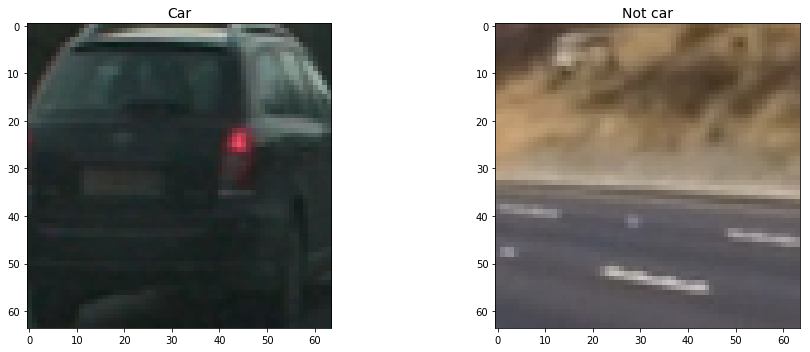

In [5]:
image_of_car = cv2.cvtColor(cv2.imread(car[np.random.randint(0, len(car))]), cv2.COLOR_BGR2RGB)
image_of_ncar = cv2.cvtColor(cv2.imread(n_car[np.random.randint(0, len(n_car))]), cv2.COLOR_BGR2RGB)

plot_multiple([image_of_car, image_of_ncar], title=['Car', 'Not car'])

## Feature Extraction

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  block_norm ='L2',
                                  visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       block_norm ='L2',
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [8]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



In [10]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Helper Functions For Image Conversion in Various Spaces

In [13]:
def channel(img, ch):
    return img[:, :, ch]

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def rgb2lab(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hls(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hsv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2yuv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]
    
    
def rgb2YCrCb(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]


    
def white_select(img): 
    lower = np.array([0,210,0], dtype=np.uint8)
    upper = np.array([360,255,255], dtype=np.uint8)
    
    channel_h = img[:, :, 0]
    channel_l = img[:, :, 1]
    channel_s = img[:, :, 2]
    
    binary_output = np.zeros_like(img[:,:,0])
    binary_output[((channel_h > lower[0]) & (channel_h <= upper[0])) 
                  & ((channel_l > lower[1]) & (channel_l <= upper[1])) 
                  & ((channel_s > lower[2]) & (channel_s <= upper[2]))] = 1
    
    return binary_output

def channel_thresholding(img, ch, thresh=(0, 255)):
    channel = img[:,:,ch]
    binary_output = np.zeros_like(channel)
    binary_output[(channel>thresh[0]) & (channel<=thresh[1])] = 1

    return binary_output

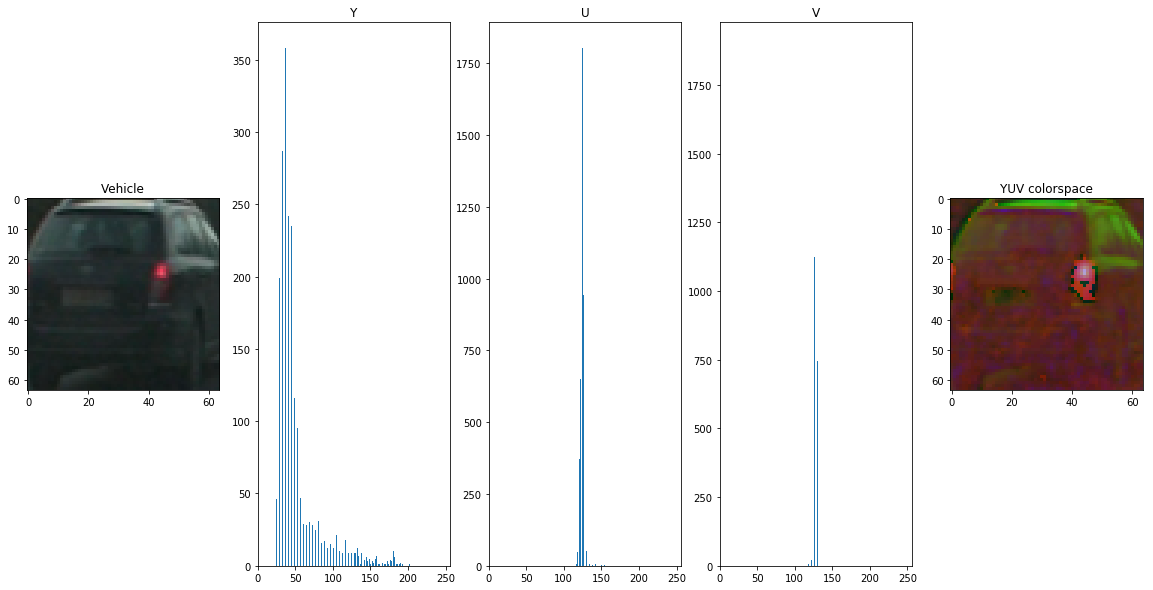

In [14]:
ch1,ch2,ch3 = Color_Histogram(rgb2yuv(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("Y")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("U")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2hls(image_of_car))
axes[4].set_title("YUV colorspace")

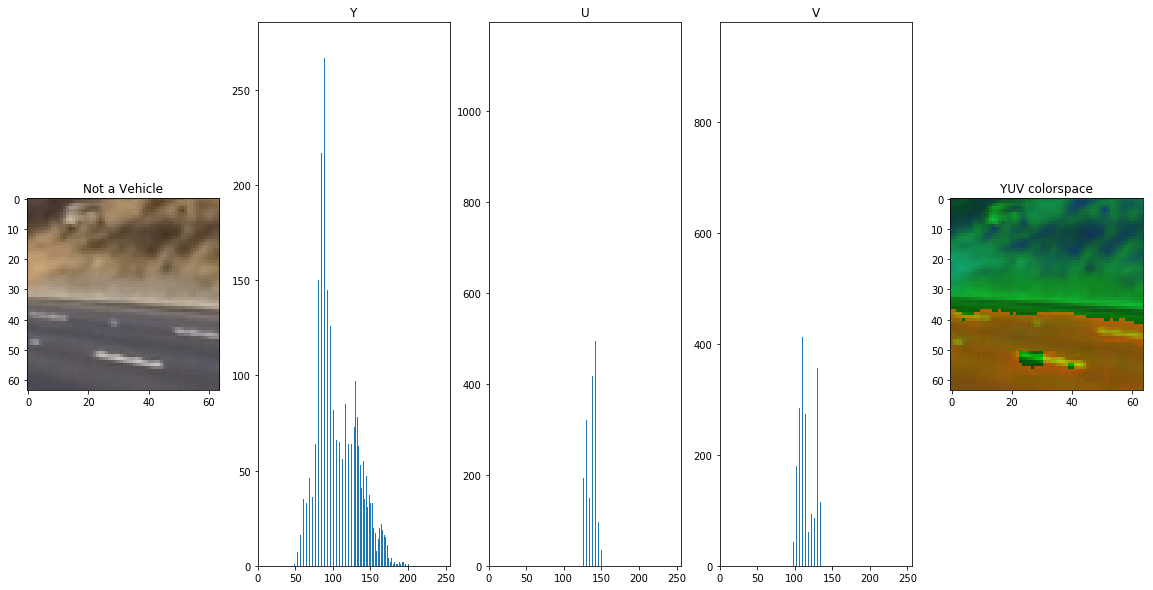

In [15]:
ch1,ch2,ch3 = Color_Histogram(rgb2yuv(image_of_ncar),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_ncar)
axes[0].set_title("Not a Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("Y")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("U")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2hls(image_of_ncar))
axes[4].set_title("YUV colorspace")

In [16]:
hog_features_y, hog_img_y = get_hog_features(img=rgb2yuv(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_u, hog_img_u = get_hog_features(img=rgb2yuv(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_v, hog_img_v = get_hog_features(img=rgb2yuv(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)

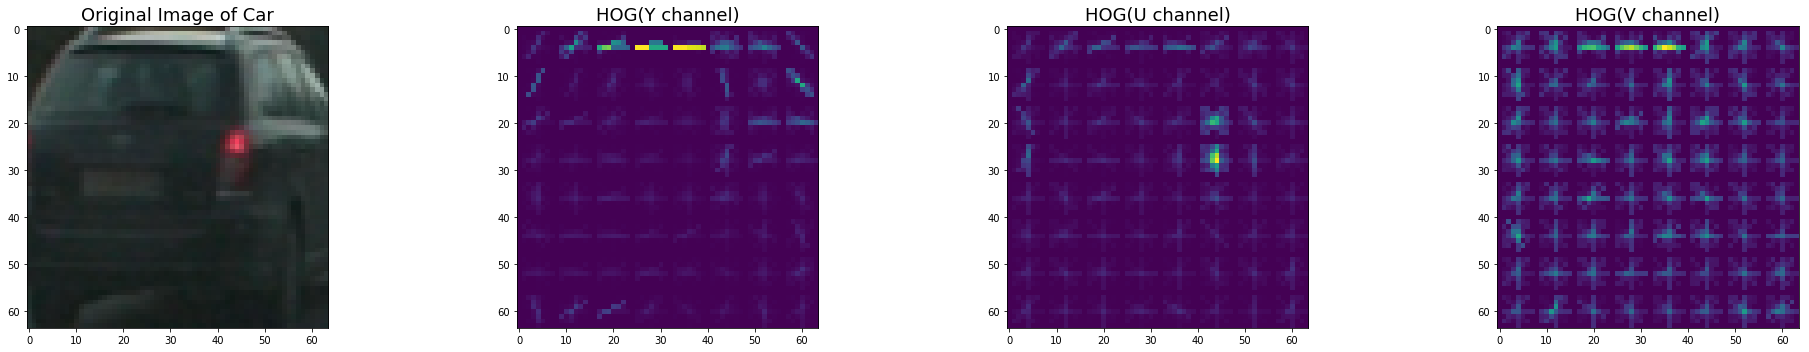

In [17]:
plot_multiple([image_of_car, hog_img_y, hog_img_u, hog_img_v], title=['Original Image of Car', 'HOG(Y channel)', 'HOG(U channel)', 'HOG(V channel)'], fontsize=18)

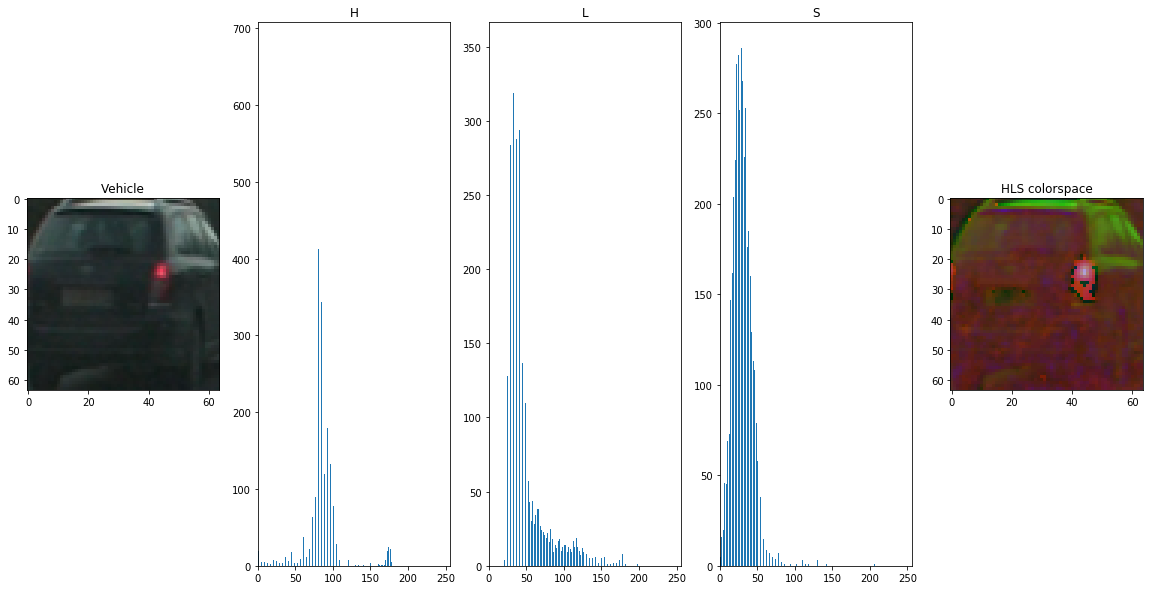

In [18]:
ch1,ch2,ch3 = Color_Histogram(rgb2hls(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("H")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("L")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("S")
axes[4].imshow(rgb2hls(image_of_car))
axes[4].set_title("HLS colorspace")

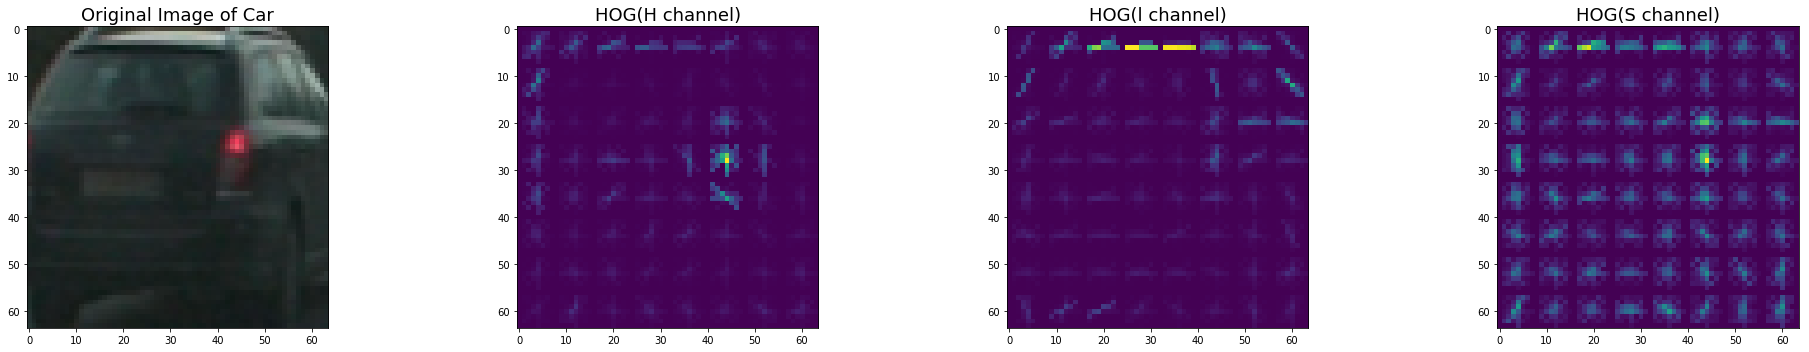

In [19]:
hog_features_h, hog_img_h = get_hog_features(img=rgb2hls(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_l, hog_img_l = get_hog_features(img=rgb2hls(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_s, hog_img_s = get_hog_features(img=rgb2hls(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_l, hog_img_s], title=['Original Image of Car', 'HOG(H channel)', 'HOG(l channel)', 'HOG(S channel)'], fontsize=18)

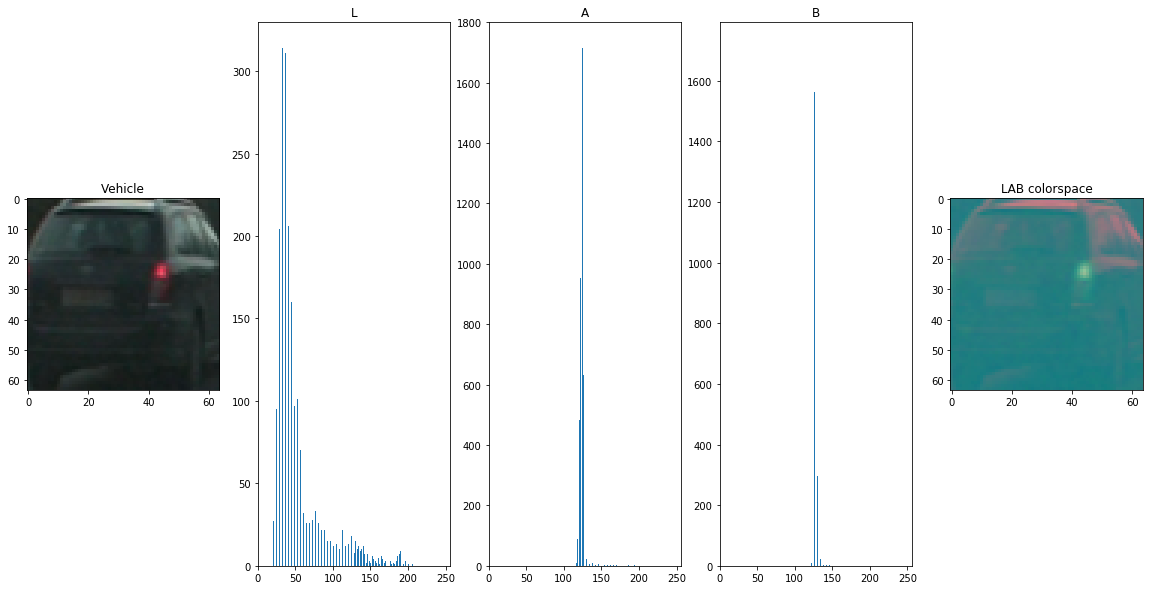

In [20]:
ch1,ch2,ch3 = Color_Histogram(rgb2lab(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("L")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("A")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("B")
axes[4].imshow(rgb2lab(image_of_car))
axes[4].set_title("LAB colorspace")

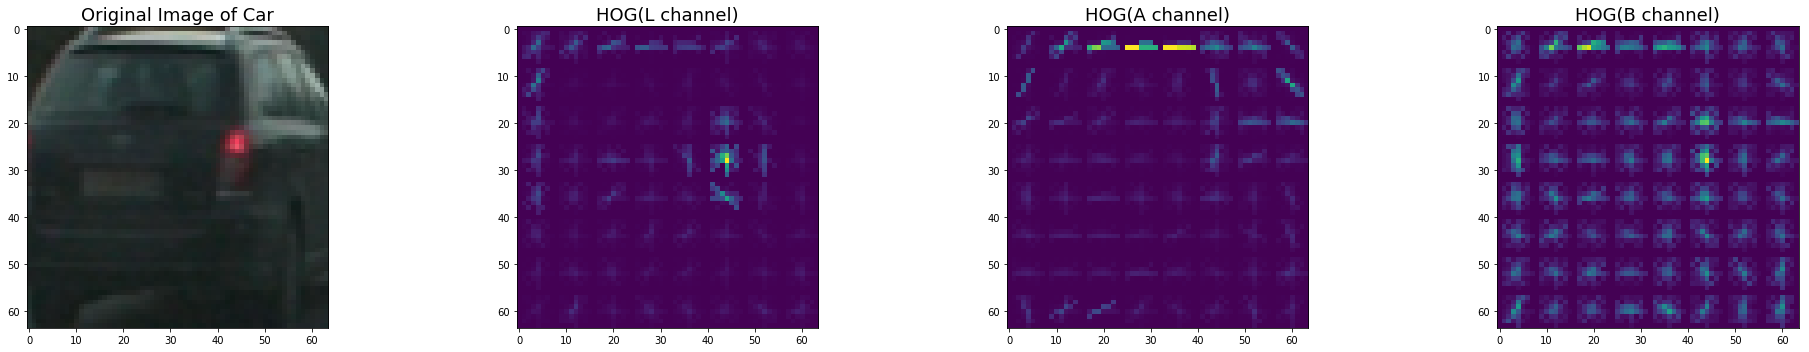

In [21]:
hog_features_l, hog_img_l = get_hog_features(img=rgb2lab(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_a, hog_img_a = get_hog_features(img=rgb2lab(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_b, hog_img_b = get_hog_features(img=rgb2lab(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_l, hog_img_s], title=['Original Image of Car', 'HOG(L channel)', 'HOG(A channel)', 'HOG(B channel)'], fontsize=18)

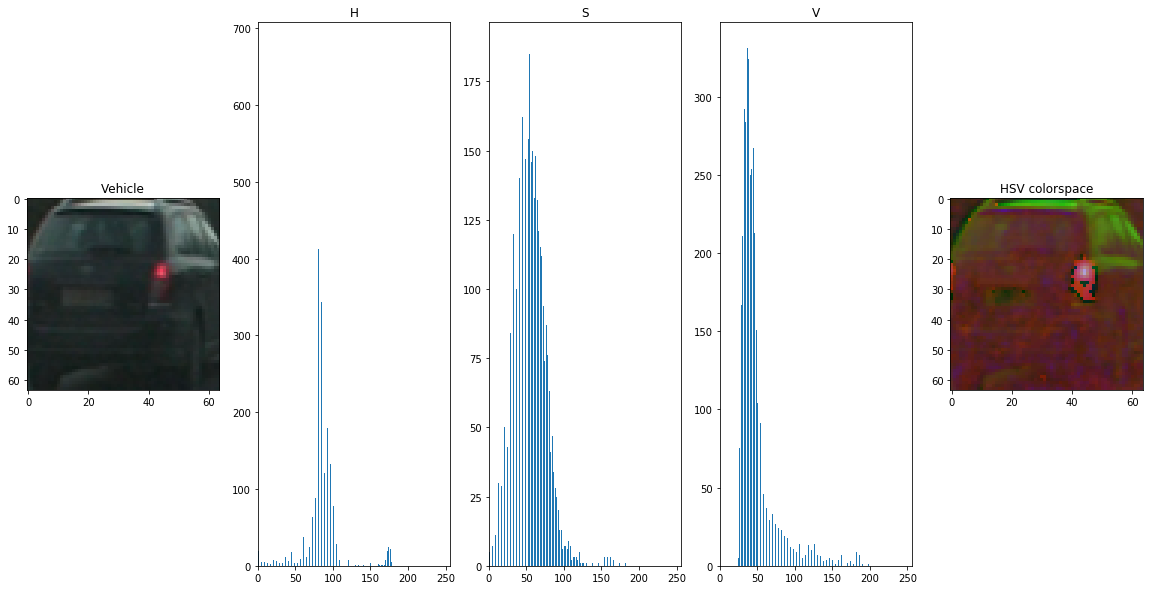

In [22]:
ch1,ch2,ch3 = Color_Histogram(rgb2hsv(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("H")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("S")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2hls(image_of_car))
axes[4].set_title("HSV colorspace")

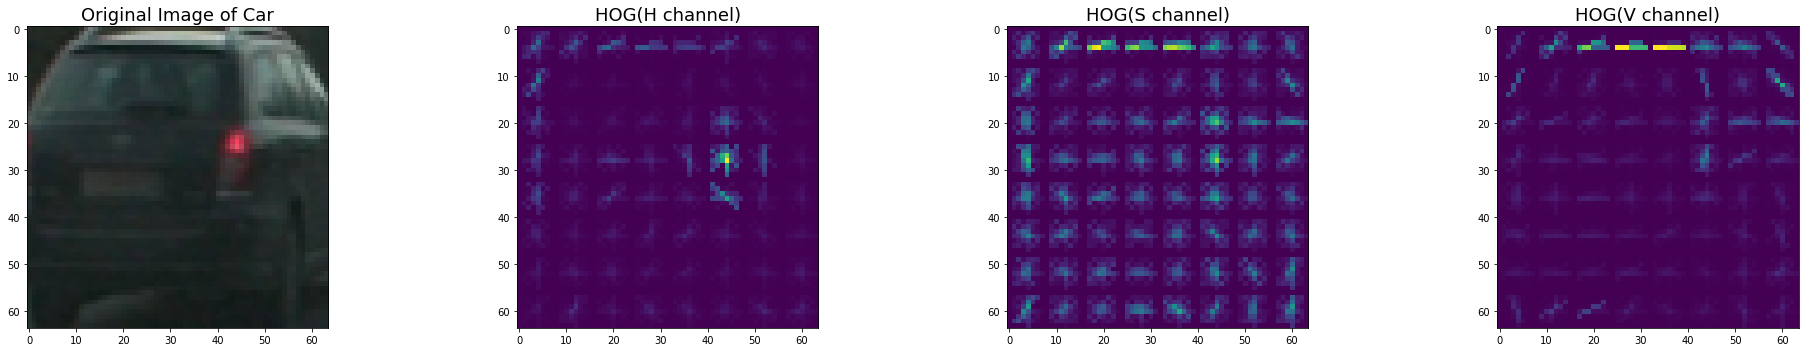

In [23]:
hog_features_h, hog_img_h = get_hog_features(img=rgb2hsv(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_s, hog_img_s = get_hog_features(img=rgb2hsv(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_v, hog_img_v = get_hog_features(img=rgb2hsv(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_s, hog_img_v], title=['Original Image of Car', 'HOG(H channel)', 'HOG(S channel)', 'HOG(V channel)'], fontsize=18)

In [24]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [ ]:
print(color_space,spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
print('Get Car Features')
car_features = extract_features(car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print('Get Non Car Features')
notcar_features = extract_features(n_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('Preparing Dataset')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


YUV (32, 32) 32 9 8 2 ALL True True True
Get Car Features
Get Non Car Features


In [25]:
parameters = [color_space ,orient, pix_per_cell, cell_per_block, hog_channel,spatial_size ,hist_bins,spatial_feat,hist_feat ,hog_feat, y_start_stop]


In [26]:
parameters

['YUV', 9, 8, 2, 'ALL', (32, 32), 32, True, True, True, [None, None]]

In [36]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["parameters"] = parameters
dist_pickle["scaler"] = X_scaler
pickle.dump(dist_pickle, open( "svc_pickle.p", "wb" ) )

In [27]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
parameters = dist_pickle["parameters"]
X_scaler = dist_pickle["scaler"]
print('Classifier data has been loaded')

Classifier data has been loaded


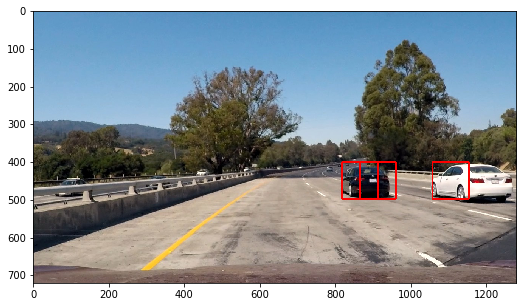

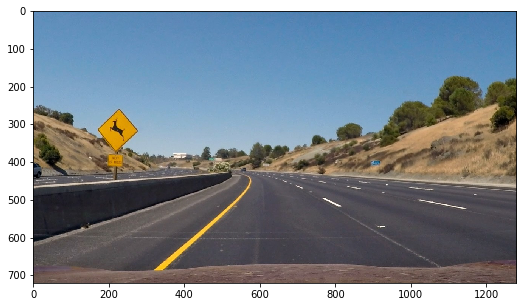

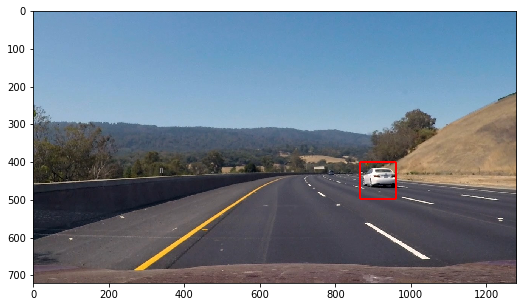

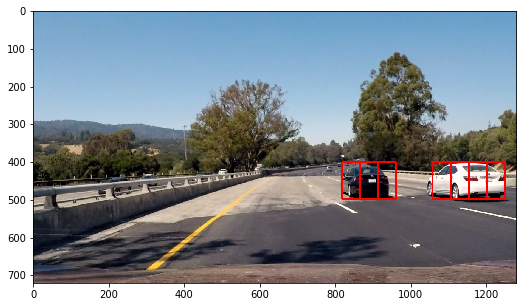

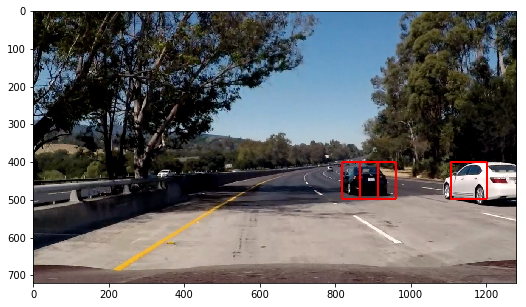

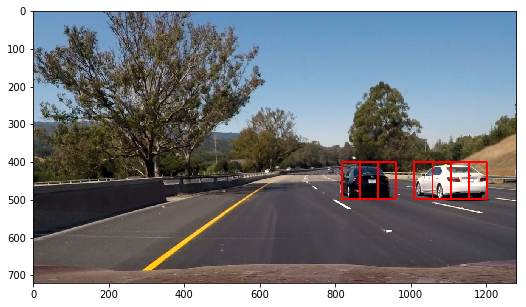

In [28]:
test = glob.glob('test_images/*.jpg')
for file in test:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    y_start_stop = [400, 650]
    windows = slide_window(image, 
                           x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, 
                           xy_window=(96, 96), 
                           xy_overlap=(0.5, 0.5)
                          )

    hot_windows = search_windows(image, windows, svc, X_scaler,color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=4) 
    plt.figure(figsize=(10, 5))
    plt.imshow(window_img)
    plt.show()

In [63]:
def find_cars(img, ystart=400, ystop=650, xstart=0, xstop=1280, scale=1.5, cells_per_step=2, svc=svc, X_scaler=X_scaler, 
              color_space = 'YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size = (32, 32), hist_bins = 32, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    
    global heat_m 
    
    draw_img = np.copy(img)    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = xstart + np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                boxes.append(box)
    
    return boxes

In [64]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [70]:
heat_m = np.zeros(shape=(720, 1280)).astype(np.int8)
def pipeline(image):
    global heat_m
    
    boxes = []
    
    ystart_values = [400, 400, 400, 450]
    ystop_values = [500, 550, 600, 700]
    
    xstart = 0
    xstop = 1280
    cells_per_step = 2
    
    scale = 1
    ystart = ystart_values[0]
    ystop = ystop_values[0]
    box_1 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1)
    
    scale = 1.3
    ystart = ystart_values[1]
    ystop = ystop_values[1]
    box_1_3 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1_3)
    
    scale = 1.7
    ystart = ystart_values[2]
    ystop = ystop_values[2]
    box_1_7 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1_7)
    
    scale = 2.5
    ystart = ystart_values[3]
    ystop = ystop_values[3]
    box_2_5 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_2_5)
    heat = np.zeros_like(image[:,:,0]).astype(np.int8)
    
    if not np.any(heat_m):
        heat_m = add_heat(heat, list(boxes))
    else:
        heat_m = np.uint8(0.7*add_heat(heat, list(boxes)) + (1-0.7)*heat_m)
    heatmap = apply_threshold(heat_m, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    resize_heatmap = cv2.resize(np.dstack((heatmap, heatmap, heatmap))*255,(192,154))#Resize the image to fit the picture in the video
    x_offset = 50
    y_offset = 50
    draw_img[y_offset:y_offset+resize_heatmap.shape[0],x_offset:x_offset+resize_heatmap.shape[1]] = resize_heatmap
    
    
    
    return draw_img

In [71]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")


white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  5%|████▎                                                                           | 67/1261 [01:08<25:53,  1.30s/it]


 11%|████████▍                                                                      | 135/1261 [02:27<17:12,  1.09it/s]


 16%|████████████▋                                                                  | 203/1261 [03:33<18:38,  1.06s/it]


 21%|████████████████▉                                                              | 271/1261 [04:49<17:05,  1.04s/it]


 27%|█████████████████████▏                                                         | 339/1261 [06:00<14:24,  1.07it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [07:13<15:10,  1.07s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [08:45<16:37,  1.27s/it]


 43%|██████████████████████████████████                                             | 543/1261 [10:03<16:20,  1.37s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [12:03<18:40,  1.72s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [14:02<16:41,  1.72s/it]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [15:21<09:00,  1.05s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [16:41<08:56,  1.20s/it]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [18:09<07:26,  1.18s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [19:43<06:40,  1.29s/it]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [21:22<04:03,  1.01s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [22:42<03:10,  1.10s/it]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [24:24<02:35,  1.46s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [25:44<00:47,  1.26s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:30<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 26min 35s
